In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.regression.linear_model import OLS

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from pathlib import Path  
import random

# Scikit-Learn models:

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import catboost as cbt
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler






# LSTM:

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import LSTM


# ARIMA Model:

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse


import pickle
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


# df = pd.read_excel("data/Argent_AFO_46045_SS_ship.xlsx")
df = pd.read_csv("data/train.csv")

In [2]:
# def load_data(file_name):
#     return pd.read_csv(file_name)


# df = df[["Created", "Sku", "AdjustmentQty"]]
# df.rename(columns={"Created": "Date", "AdjustmentQty": "ShippedQty"}, inplace=True)
df = df[["date", "item", "sales"]]
df.rename(columns={"date": "Date", "sales": "ShippedQty", "item": "Sku"}, inplace=True)

print("min", df["Date"].min())
print("max", df["Date"].max())

min 2013-01-01
max 2017-12-31


In [3]:
max_sku = df.loc[df['ShippedQty'].idxmax(), 'Sku']
df = df[df['Sku'] == max_sku]
df.shape

(18260, 3)

## Data Aggregtion

/var/folders/bf/t7zr8nds6f727x199sygjpbh0000gn/T/ipykernel_86020/3960586677.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(d_df["Date"][::max(1, len(d_df) // 10)], rotation=45)


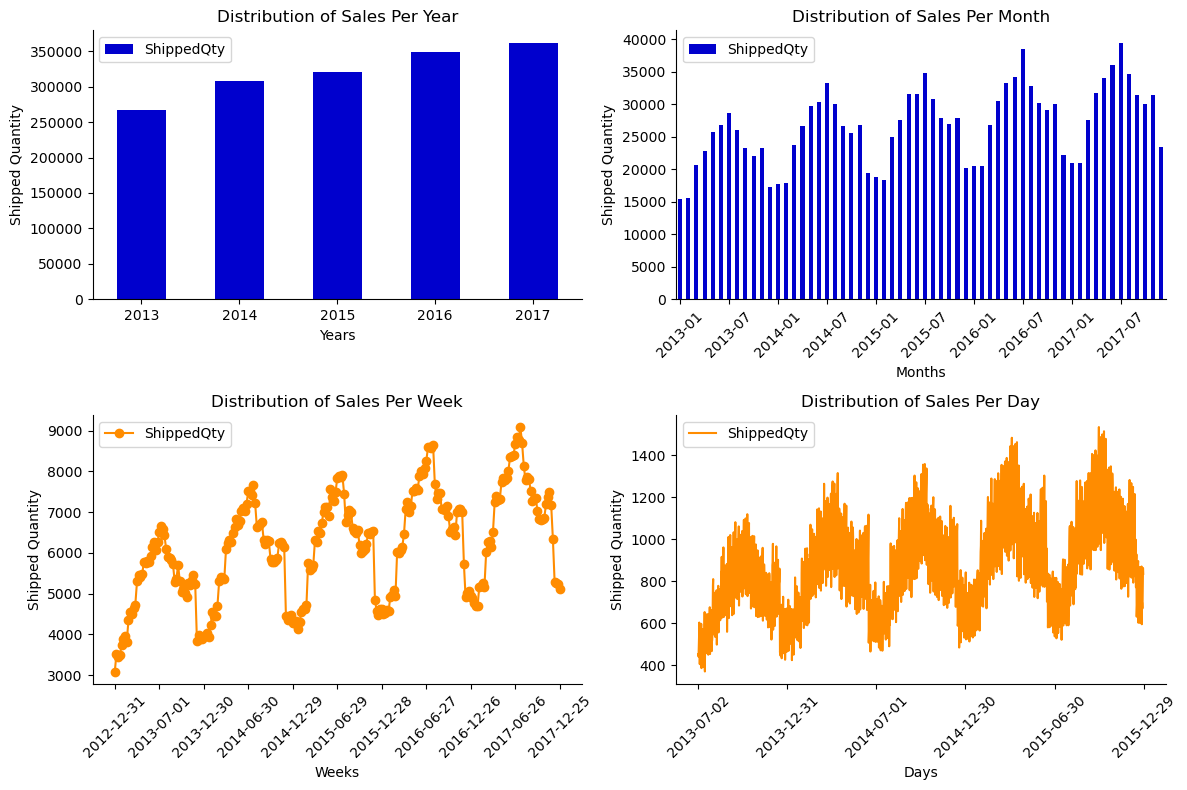

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def sales_aggregation(data, time="monthly"):
    data = data.copy()

    # Convert 'Date' column to datetime format
    data["Date"] = pd.to_datetime(data["Date"])

    # Aggregate based on selected time period
    if time == "monthly":
        data["Date"] = data["Date"].dt.to_period("M").astype(str)
    elif time == "yearly":
        data["Date"] = data["Date"].dt.to_period("Y").astype(str)
    elif time == "weekly":
        data["Date"] = data["Date"].dt.to_period("W").apply(lambda x: x.start_time.strftime('%Y-%m-%d'))
    elif time == "daily":
        data["Date"] = data["Date"].dt.date  # Keeps full date
    else:
        raise ValueError("Invalid time period. Choose from 'daily', 'weekly', 'monthly', or 'yearly'.")

    # Sum shipped quantity per selected time period
    data = data.groupby("Date")["ShippedQty"].sum().reset_index()

    # Convert date column back to datetime format (for correct plotting)
    if time in ["monthly", "yearly"]:
        data["Date"] = pd.to_datetime(data["Date"])

    return data


# Aggregated DataFrames
m_df = sales_aggregation(df, "monthly")
y_df = sales_aggregation(df, "yearly")
w_df = sales_aggregation(df, "weekly")
d_df = sales_aggregation(df, "daily")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Yearly sales (Bar Chart)
y_df.plot(kind="bar", x="Date", y="ShippedQty", color="mediumblue", ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Sales Per Year")
axes[0, 0].set_xlabel("Years")
axes[0, 0].set_ylabel("Shipped Quantity")
axes[0, 0].set_xticklabels(y_df["Date"].dt.year, rotation=0)  # Show only years

# Monthly sales (Bar Chart)
m_df.plot(kind="bar", x="Date", y="ShippedQty", color="mediumblue", ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Sales Per Month")
axes[0, 1].set_xlabel("Months")
axes[0, 1].set_ylabel("Shipped Quantity")
tick_interval = max(1, len(m_df) // 10)  
axes[0, 1].set_xticks(np.arange(0, len(m_df), tick_interval))

# Format and apply labels at the selected ticks
axes[0, 1].set_xticklabels(m_df["Date"].dt.strftime('%Y-%m')[::tick_interval], rotation=45)
# axes[0, 1].set_xticks(range(0, len(m_df), max(1, len(m_df) // 10)))
# axes[0, 1].set_xticklabels(m_df["Date"].dt.strftime('%Y-%m'), rotation=45)  # Show Year-Month


# Weekly sales (Line Chart)
w_df.plot(marker="o", x="Date", y="ShippedQty", color="darkorange", ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Sales Per Week")
axes[1, 0].set_xlabel("Weeks")
axes[1, 0].set_ylabel("Shipped Quantity")
axes[1, 0].set_xticks(range(0, len(w_df), max(1, len(w_df) // 10)))  # Reduce number of x-ticks
axes[1, 0].set_xticklabels(w_df["Date"][::max(1, len(w_df) // 10)], rotation=45)  # Avoid overlap

# Daily sales (Line Chart)
d_df.plot(x="Date", y="ShippedQty", color="darkorange", ax=axes[1, 1])
axes[1, 1].set_title("Distribution of Sales Per Day")
axes[1, 1].set_xlabel("Days")
axes[1, 1].set_ylabel("Shipped Quantity")
# axes[1, 1].set_xticks(range(0, len(d_df), max(1, len(d_df) // 10)))  # Reduce x-ticks
axes[1, 1].set_xticklabels(d_df["Date"][::max(1, len(d_df) // 10)], rotation=45)

# Formatting
plt.tight_layout()
sns.despine()
plt.show()

In [13]:
d_df

# # Aggregated DataFrames
# m_df = sales_aggregation(df, "monthly")
# y_df = sales_aggregation(df, "yearly")
# w_df = sales_aggregation(df, "weekly")
# d_df = sales_aggregation(df, "daily")

Date  ShippedQty
0     2013-01-01         453
1     2013-01-02         442
2     2013-01-03         487
3     2013-01-04         533
4     2013-01-05         604
...          ...         ...
1821  2017-12-27         670
1822  2017-12-28         675
1823  2017-12-29         778
1824  2017-12-30         864
1825  2017-12-31         836

[1826 rows x 2 columns]

## Missing Values

## Outlier Handling

Number of outliers detected: 2


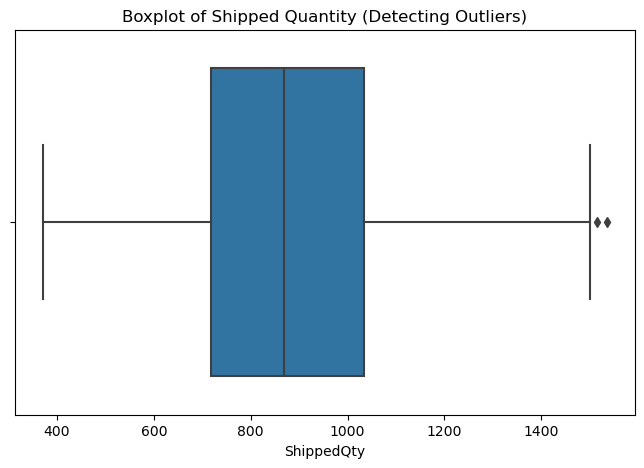

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute IQR
Q1 = d_df["ShippedQty"].quantile(0.25)
Q3 = d_df["ShippedQty"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = d_df[(d_df["ShippedQty"] < lower_bound) | (d_df["ShippedQty"] > upper_bound)]

print(f"Number of outliers detected: {len(outliers)}")

# Visualize with Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=d_df["ShippedQty"])
plt.title("Boxplot of Shipped Quantity (Detecting Outliers)")
plt.show()



# Cap extreme values at the upper and lower bounds
d_df["ShippedQty"] = np.where(d_df["ShippedQty"] > upper_bound, upper_bound,
                             np.where(d_df["ShippedQty"] < lower_bound, lower_bound, d_df["ShippedQty"]))

## Transform the Data
Why Transform the Data?
- Fix Skewed Distributions ‚Üí Many demand datasets are right-skewed due to rare high-sales events.
- Stabilize Variance ‚Üí Reducing variance improves forecasting model accuracy.
- Improve Normality ‚Üí Some models (like ARIMA, Linear Regression) perform better with normally distributed data.


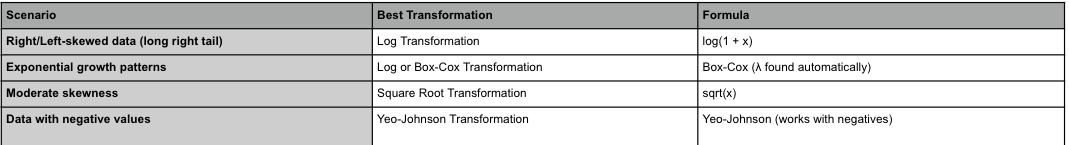


Skewness of ShippedQty: 0.21


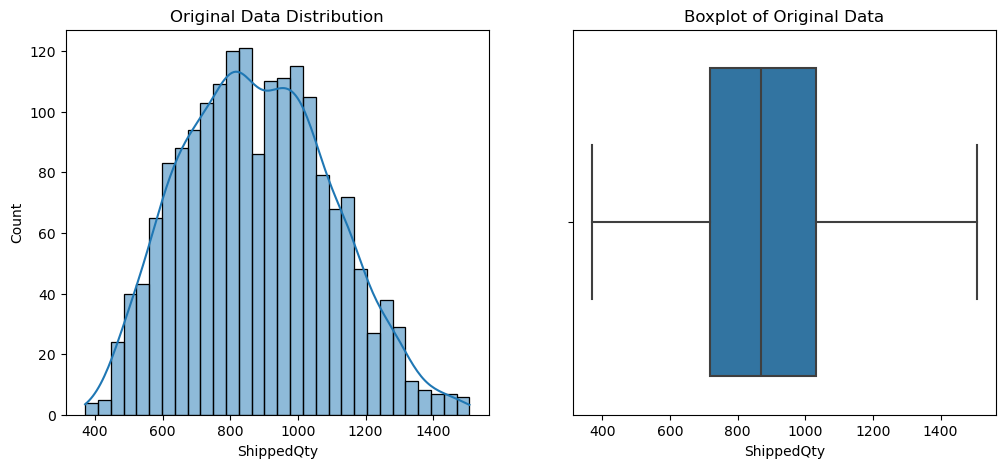

In [15]:
from scipy.stats import skew

# Compute skewness
skewness = d_df["ShippedQty"].skew()
print(f"Skewness of ShippedQty: {skewness:.2f}")

# Visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(d_df["ShippedQty"], bins=30, kde=True)
plt.title("Original Data Distribution")

plt.subplot(1, 2, 2)
sns.boxplot(x=d_df["ShippedQty"])
plt.title("Boxplot of Original Data")

plt.show()

In [16]:
# Log Transformation

# d_df["ShippedQty_Log"] = np.log1p(d_df["ShippedQty"])
# d_df["ShippedQty_Sqrt"] = np.sqrt(d_df["ShippedQty"])

## Step 3: Scaling the Data
### Applying Scaling



In [17]:
# X = d_df[["ShippedQty"]].values  
X = d_df[["ShippedQty"]].values

# Apply different scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

d_df["MinMaxScaled"] = minmax_scaler.fit_transform(X)
d_df["StandardScaled"] = standard_scaler.fit_transform(X)
d_df["RobustScaled"] = robust_scaler.fit_transform(X)

# Display first few rows
print(d_df.head())

         Date  ShippedQty  MinMaxScaled  StandardScaled  RobustScaled
0  2013-01-01       453.0      0.072207       -1.966937     -1.314331
1  2013-01-02       442.0      0.062521       -2.017573     -1.349169
2  2013-01-03       487.0      0.102146       -1.810424     -1.206651
3  2013-01-04       533.0      0.142653       -1.598672     -1.060966
4  2013-01-05       604.0      0.205173       -1.271837     -0.836105


### Visualizing Scaling Effects

* many outliers ‚Üí Use RobustScaler (preserves spread but reduces extreme values).
* normally distributed ‚Üí Use StandardScaler (best for models requiring normal distribution).
* using deep learning models (LSTMs, RNNs, etc.) ‚Üí Use MinMaxScaler (suitable for 0-1 range).

In [24]:
# Compare statistics for each scaling method
scaling_summary = d_df[["ShippedQty", "MinMaxScaled", "StandardScaled", "RobustScaled"]].describe()
print(scaling_summary.round(decimals=3))

       ShippedQty  MinMaxScaled  StandardScaled  RobustScaled
count    1826.000      1826.000        1826.000      1826.000
mean      880.288         0.448           0.000         0.039
std       217.295         0.191           1.000         0.688
min       371.000         0.000          -2.344        -1.574
25%       717.250         0.305          -0.751        -0.477
50%       868.000         0.438          -0.057         0.000
75%      1033.000         0.583           0.703         0.523
max      1506.625         1.000           2.883         2.023


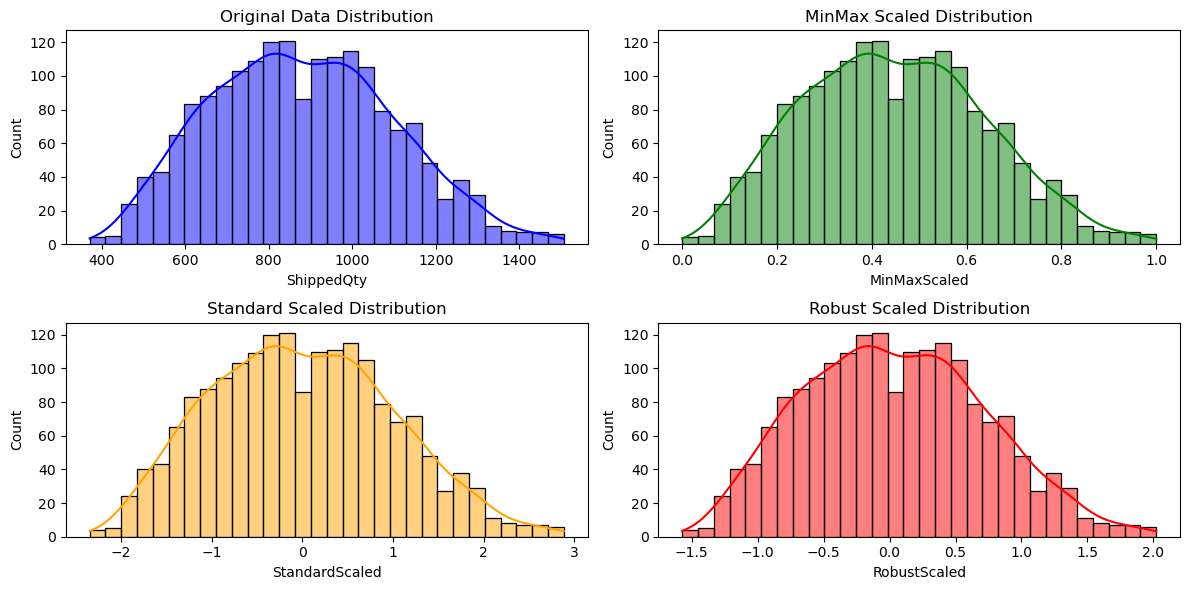

In [26]:
plt.figure(figsize=(12, 6))

# Original Data
plt.subplot(2, 2, 1)
sns.histplot(d_df["ShippedQty"], bins=30, kde=True, color="blue")
plt.title("Original Data Distribution")

# MinMaxScaler
plt.subplot(2, 2, 2)
sns.histplot(d_df["MinMaxScaled"], bins=30, kde=True, color="green")
plt.title("MinMax Scaled Distribution")

# StandardScaler
plt.subplot(2, 2, 3)
sns.histplot(d_df["StandardScaled"], bins=30, kde=True, color="orange")
plt.title("Standard Scaled Distribution")

# RobustScaler
plt.subplot(2, 2, 4)
sns.histplot(d_df["RobustScaled"], bins=30, kde=True, color="red")
plt.title("Robust Scaled Distribution")

plt.tight_layout()
plt.show()

## Feature Engineeing 

### Feature Engineering for Statistical Models (ARIMA, SARIMA, ARIMAX)

In [28]:
d_df.columns

Index(['Date', 'ShippedQty', 'MinMaxScaled', 'StandardScaled', 'RobustScaled'], dtype='object')

In [30]:
# Prepare d_df for Statistical Models
d_df_stat = d_df.copy()

# Keep only necessary columns for ARIMA/SARIMA (no external variables)
d_df_stat = d_df_stat[["Date", "ShippedQty"]]

# Apply differencing for stationarity (ARIMA requires this)
d_df_stat["ShippedQty_Diff"] = d_df_stat["ShippedQty"].diff()

# Drop NaN values after differencing
d_df_stat = d_df_stat.dropna().reset_index(drop=True)

In [31]:
print(d_df_stat.head())

         Date  ShippedQty  ShippedQty_Diff
0  2013-01-02       442.0            -11.0
1  2013-01-03       487.0             45.0
2  2013-01-04       533.0             46.0
3  2013-01-05       604.0             71.0
4  2013-01-06       567.0            -37.0


###  Feature Engineering for Machine Learning Models

In [33]:
# Prepare d_df for Machine Learning Models using ShippedQty_Sqrt
d_df_ml = d_df.copy()

# Extract basic date-based features
d_df_ml["Date"] = pd.to_datetime(d_df_ml["Date"])
d_df_ml["DayOfWeek"] = d_df_ml["Date"].dt.dayofweek
d_df_ml["Month"] = d_df_ml["Date"].dt.month

# Add lag features using ShippedQty_Sqrt
d_df_ml["Lag_1"] = d_df_ml["ShippedQty"].shift(1)
d_df_ml["Lag_7"] = d_df_ml["ShippedQty"].shift(7)
d_df_ml["Lag_14"] = d_df_ml["ShippedQty"].shift(14)
d_df_ml["Lag_30"] = d_df_ml["ShippedQty"].shift(30)

# Add rolling statistics using ShippedQty_Sqrt
d_df_ml["Rolling_7"] = d_df_ml["ShippedQty"].rolling(window=7).mean()
d_df_ml["Rolling_7_Std"] = d_df_ml["ShippedQty"].rolling(window=7).std()

# Add cyclical encoding for date-based features
d_df_ml["DayOfWeek_Sin"] = np.sin(2 * np.pi * d_df_ml["DayOfWeek"] / 7)
d_df_ml["DayOfWeek_Cos"] = np.cos(2 * np.pi * d_df_ml["DayOfWeek"] / 7)
d_df_ml["Month_Sin"] = np.sin(2 * np.pi * d_df_ml["Month"] / 12)
d_df_ml["Month_Cos"] = np.cos(2 * np.pi * d_df_ml["Month"] / 12)

# Add feature interactions using ShippedQty_Sqrt
d_df_ml["Lag_1_to_Lag_7_Ratio"] = d_df_ml["Lag_1"] / (d_df_ml["Lag_7"] + 1e-5)
d_df_ml["Lag_7_to_Lag_14_Ratio"] = d_df_ml["Lag_7"] / (d_df_ml["Lag_14"] + 1e-5)

# Drop NaN values after feature engineering
d_df_ml = d_df_ml.dropna().reset_index(drop=True)

In [34]:
print(d_df_ml.head())

        Date  ShippedQty  MinMaxScaled  StandardScaled  RobustScaled  \
0 2013-01-31       514.0      0.125922       -1.686135     -1.121140   
1 2013-02-01       627.0      0.225427       -1.165961     -0.763262   
2 2013-02-02       604.0      0.205173       -1.271837     -0.836105   
3 2013-02-03       643.0      0.239516       -1.092308     -0.712589   
4 2013-02-04       459.0      0.077490       -1.939317     -1.295329   

   DayOfWeek  Month  Lag_1  Lag_7  Lag_14  Lag_30   Rolling_7  Rolling_7_Std  \
0          3      1  455.0  497.0   451.0   453.0  510.428571      85.993909   
1          4      2  514.0  516.0   516.0   442.0  526.285714      96.753491   
2          5      2  627.0  544.0   552.0   487.0  534.857143     101.142521   
3          6      2  604.0  654.0   573.0   533.0  533.285714      99.046646   
4          0      2  643.0  371.0   392.0   604.0  545.857143      78.461091   

   DayOfWeek_Sin  DayOfWeek_Cos  Month_Sin  Month_Cos  Lag_1_to_Lag_7_Ratio  \
0      

### Feature Engineering for Neural Networks

In [35]:
# Prepare d_df for Neural Networks
d_df_nn = d_df.copy()

# Convert Date column to datetime
d_df_nn["Date"] = pd.to_datetime(d_df_nn["Date"])

# Extract basic cyclical date-based features
d_df_nn["DayOfWeek"] = d_df_nn["Date"].dt.dayofweek
d_df_nn["Month"] = d_df_nn["Date"].dt.month

# Cyclical encoding for date-based features
d_df_nn["DayOfWeek_Sin"] = np.sin(2 * np.pi * d_df_nn["DayOfWeek"] / 7)
d_df_nn["DayOfWeek_Cos"] = np.cos(2 * np.pi * d_df_nn["DayOfWeek"] / 7)
d_df_nn["Month_Sin"] = np.sin(2 * np.pi * d_df_nn["Month"] / 12)
d_df_nn["Month_Cos"] = np.cos(2 * np.pi * d_df_nn["Month"] / 12)

# Drop unnecessary categorical columns that NN models don't need
d_df_nn = d_df_nn.drop(columns=["DayOfWeek", "Month"])

# Drop NaN values (if any)
d_df_nn = d_df_nn.dropna().reset_index(drop=True)

In [36]:
print(d_df_nn.head())

        Date  ShippedQty  MinMaxScaled  StandardScaled  RobustScaled  \
0 2013-01-01       453.0      0.072207       -1.966937     -1.314331   
1 2013-01-02       442.0      0.062521       -2.017573     -1.349169   
2 2013-01-03       487.0      0.102146       -1.810424     -1.206651   
3 2013-01-04       533.0      0.142653       -1.598672     -1.060966   
4 2013-01-05       604.0      0.205173       -1.271837     -0.836105   

   DayOfWeek_Sin  DayOfWeek_Cos  Month_Sin  Month_Cos  
0       0.781831       0.623490        0.5   0.866025  
1       0.974928      -0.222521        0.5   0.866025  
2       0.433884      -0.900969        0.5   0.866025  
3      -0.433884      -0.900969        0.5   0.866025  
4      -0.974928      -0.222521        0.5   0.866025  


## Perform Train-Test Split (Chronological Order)

We will split the dataset 80-20, keeping the most recent 20% as the test set.

In [39]:
from sklearn.preprocessing import MinMaxScaler

# Stat
# Define train-test split ratio (80-20)
train_size = int(len(d_df_stat) * 0.8)

# Train-Test Split (Chronological Order)
train_stat, test_stat = d_df_stat.iloc[:train_size], d_df_stat.iloc[train_size:]

print(f"Stat Models -> Train size: {len(train_stat)}, Test size: {len(test_stat)}")

# ML
# Define train-test split ratio (80-20)
train_size = int(len(d_df_ml) * 0.8)

# Train-Test Split (Chronological Order)
X_train_ml, X_test_ml = d_df_ml.iloc[:train_size].drop(columns=["Date", "ShippedQty"]), d_df_ml.iloc[train_size:].drop(columns=["Date", "ShippedQty"])
y_train_ml, y_test_ml = d_df_ml.iloc[:train_size]["ShippedQty"], d_df_ml.iloc[train_size:]["ShippedQty"]

print(f"ML Models -> Train size: {len(X_train_ml)}, Test size: {len(X_test_ml)}")

# Apply MinMax Scaling to ML Models
minmax_scaler = MinMaxScaler()

X_train_ml = minmax_scaler.fit_transform(X_train_ml)
X_test_ml = minmax_scaler.transform(X_test_ml)

# NN
# Define train-test split ratio (80-20)
train_size = int(len(d_df_nn) * 0.8)

# Train-Test Split (Chronological Order)
X_train_nn, X_test_nn = d_df_nn.iloc[:train_size].drop(columns=["Date", "ShippedQty"]), d_df_nn.iloc[train_size:].drop(columns=["Date", "ShippedQty"])
y_train_nn, y_test_nn = d_df_nn.iloc[:train_size]["ShippedQty"], d_df_nn.iloc[train_size:]["ShippedQty"]

print(f"NN Models -> Train size: {len(X_train_nn)}, Test size: {len(X_test_nn)}")

# Apply MinMax Scaling to NN Models
X_train_nn = minmax_scaler.fit_transform(X_train_nn)
X_test_nn = minmax_scaler.transform(X_test_nn)

Stat Models -> Train size: 1460, Test size: 365
ML Models -> Train size: 1436, Test size: 360
NN Models -> Train size: 1460, Test size: 366


### Visualize Train-Test Split

In [41]:
# train_size_stat = int(len(d_df_stat) * 0.8)
# train_size_ml = int(len(d_df_ml) * 0.8)
# train_size_nn = int(len(d_df_nn) * 0.8)

# # Step 1: Visualize Train-Test Split for Statistical Models
# plt.figure(figsize=(12, 4))
# plt.plot(d_df_stat["Date"], d_df_stat["ShippedQty"], label="Full Data", color="gray", linestyle="dotted")
# plt.plot(train_stat["Date"], train_stat["ShippedQty"], label="Train Data", color="blue")
# plt.plot(test_stat["Date"], test_stat["ShippedQty"], label="Test Data", color="red")
# plt.axvline(x=d_df_stat["Date"].iloc[train_size_stat], color="black", linestyle="--", label="Split Point")
# plt.legend()
# plt.title("Train-Test Split for Statistical Models (ARIMA/SARIMA)")
# plt.xlabel("Date")
# plt.ylabel("ShippedQty")
# plt.show()

# # Step 2: Visualize Train-Test Split for Machine Learning Models
# plt.figure(figsize=(12, 4))
# plt.plot(d_df_ml["Date"], d_df_ml["ShippedQty"], label="Full Data", color="gray", linestyle="dotted")
# plt.plot(d_df_ml["Date"].iloc[:train_size_ml], y_train_ml, label="Train Data", color="blue")
# plt.plot(d_df_ml["Date"].iloc[train_size_ml:], y_test_ml, label="Test Data", color="red")
# plt.axvline(x=d_df_ml["Date"].iloc[train_size_ml], color="black", linestyle="--", label="Split Point")
# plt.legend()
# plt.title("Train-Test Split for Machine Learning Models")
# plt.xlabel("Date")
# plt.ylabel("ShippedQty")
# plt.show()

# # Step 3: Visualize Train-Test Split for Neural Networks
# plt.figure(figsize=(12, 4))
# plt.plot(d_df_nn["Date"], d_df_nn["ShippedQty"], label="Full Data", color="gray", linestyle="dotted")
# plt.plot(d_df_nn["Date"].iloc[:train_size_nn], y_train_nn, label="Train Data", color="blue")
# plt.plot(d_df_nn["Date"].iloc[train_size_nn:], y_test_nn, label="Test Data", color="red")
# plt.axvline(x=d_df_nn["Date"].iloc[train_size_nn], color="black", linestyle="--", label="Split Point")
# plt.legend()
# plt.title("Train-Test Split for Neural Networks")
# plt.xlabel("Date")
# plt.ylabel("ShippedQty")
plt.show()

## Traditional Statistical Models (ARIMA, SARIMA, Exponential Smoothing)

* ARIMA (Auto-Regressive Integrated Moving Average) ‚Üí Best for non-seasonal data.
* SARIMA (Seasonal ARIMA) ‚Üí Captures seasonality in demand.
* Exponential Smoothing (Simple, Holt-Winters Method) ‚Üí Captures trends and seasonal variations.
### ARIMA Model

#### Check Data Stationarity (Required for ARIMA)
* p-value < 0.05 ‚Üí Data is stationary ‚Üí ARIMA is ready to use.
* p-value ‚â• 0.05 ‚Üí Data is non-stationary ‚Üí We must apply differencing.

#### How to Interpret PACF for ARIMA?
* If PACF cuts off sharply after a few lags (e.g., lag 1 or 2) ‚Üí Use p = number of significant lags in ARIMA(p, d, q).
* If PACF gradually declines ‚Üí The process might require a higher p value or differencing (d).
* If PACF has significant lags at seasonal intervals (e.g., 7, 30, etc.) ‚Üí Suggests using SARIMA.

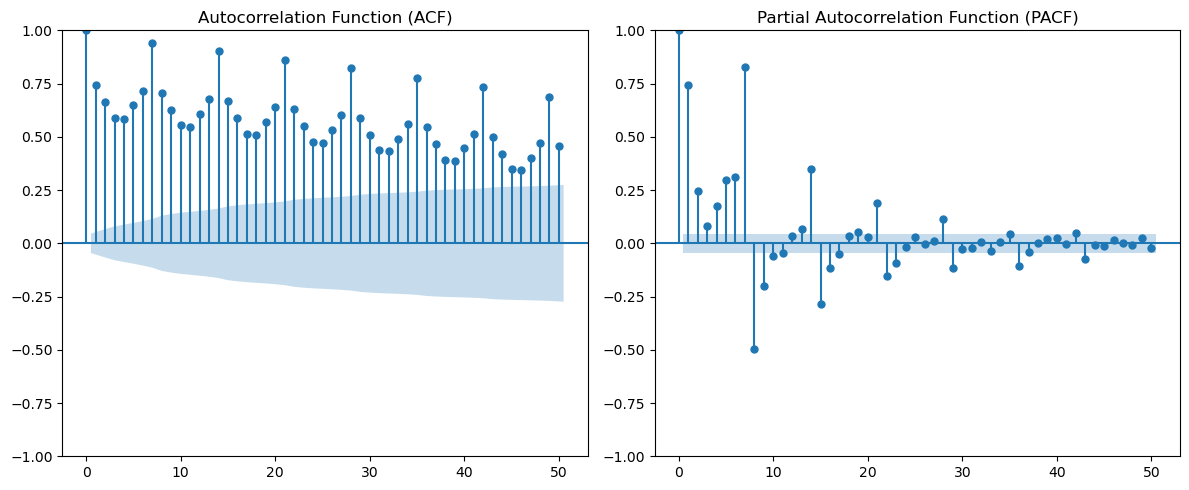

ADF Statistic: -2.8762
p-value: 0.0482
Critical Values:
	1%: -3.4349
	5%: -2.8636
	10%: -2.5678

‚úÖ Data is already stationary (p < 0.05). Proceeding with ARIMA.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57366D+00    |proj g|=  1.27263D-01


 This problem is unconstrained.



At iterate    5    f=  6.41012D+00    |proj g|=  3.26684D-02

At iterate   10    f=  6.39883D+00    |proj g|=  1.49002D-02

At iterate   15    f=  6.26671D+00    |proj g|=  1.33964D-01

At iterate   20    f=  6.20242D+00    |proj g|=  2.62690D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   4.742D-07   6.202D+00
  F =   6.2024005178348602     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


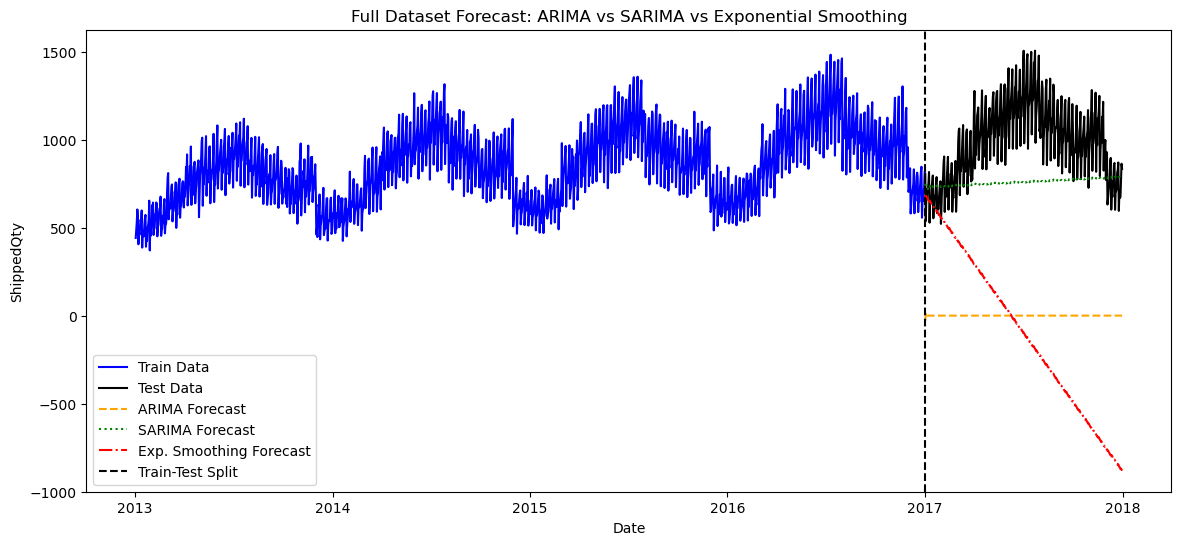

In [43]:
# Import necessary libraries
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Step 1: ACF & PACF Plots (Identifies p and q for ARIMA)
def plot_acf_pacf(data, column):
    # Drop NaN values if present
    clean_data = data[column].dropna()
    
    # Set figure size
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ACF Plot (Identifies q)
    plot_acf(clean_data, lags=50, alpha=0.05, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")

    # PACF Plot (Identifies p)
    plot_pacf(clean_data, lags=50, method="ywm", alpha=0.05, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")

    plt.tight_layout()
    plt.show()

plot_acf_pacf(d_df, "ShippedQty")

# Step 2: Check Data Stationarity (ADF Test)
def check_stationarity(data, column):
    adf_test = adfuller(data[column])
    print(f"ADF Statistic: {adf_test[0]:.4f}")
    print(f"p-value: {adf_test[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_test[4].items():
        print(f"\t{key}: {value:.4f}")

    return adf_test[1]  # Return p-value

# Step 3: Apply Differencing if Needed
def apply_differencing(data, column):
    p_value = check_stationarity(data, column)
    
    if p_value >= 0.05:
        print("\n‚ùå Data is non-stationary (p >= 0.05). Applying first-order differencing...")
        data["ShippedQty_Diff"] = data[column].diff().dropna()

        # Re-run stationarity test
        new_p_value = check_stationarity(data.dropna(), "ShippedQty_Diff")

        if new_p_value < 0.05:
            print("‚úÖ Data is now stationary after differencing.")
        else:
            print("‚ö† Data may still be non-stationary. Consider additional transformations.")
    else:
        print("\n‚úÖ Data is already stationary (p < 0.05). Proceeding with ARIMA.")

apply_differencing(train_stat, "ShippedQty")

# Step 4: Fit ARIMA Model
def fit_arima(train_data, test_data):
    p, d, q = 1, 1, 1  # Adjust based on ACF/PACF analysis
    target_col = "ShippedQty_Diff" if "ShippedQty_Diff" in train_data.columns else "ShippedQty"

    arima_model = ARIMA(train_data[target_col], order=(p, d, q))
    arima_fit = arima_model.fit()
    test_data.loc[:, "ARIMA_Forecast"] = arima_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
    return test_data

test_stat = fit_arima(train_stat, test_stat)

# Step 5: Fit SARIMA Model
def fit_sarima(train_data, test_data):
    p, d, q = 1, 1, 1  # Non-seasonal terms
    P, D, Q, S = 1, 1, 1, 12  # Seasonal terms (Assuming monthly seasonality)

    sarima_model = SARIMAX(
        train_data["ShippedQty"],
        order=(p, d, q),
        seasonal_order=(P, D, Q, S)
    )
    sarima_fit = sarima_model.fit()
    test_data.loc[:, "SARIMA_Forecast"] = sarima_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
    return test_data

test_stat = fit_sarima(train_stat, test_stat)

# Step 6: Fit Exponential Smoothing Model
def fit_exponential_smoothing(train_data, test_data):
    hw_model = ExponentialSmoothing(train_data["ShippedQty"], trend="add", seasonal="add", seasonal_periods=12)
    hw_fit = hw_model.fit()
    test_data.loc[:, "ExpSmooth_Forecast"] = hw_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    return test_data

test_stat = fit_exponential_smoothing(train_stat, test_stat)

# Step 7: Visualize Model Performance Over Entire Dataset
def plot_full_forecast(train_data, test_data):
    plt.figure(figsize=(14, 6))

    # Plot actual data (train + test)
    plt.plot(train_data["Date"], train_data["ShippedQty"], label="Train Data", color="blue")
    plt.plot(test_data["Date"], test_data["ShippedQty"], label="Test Data", color="black")

    # Plot model forecasts
    plt.plot(test_data["Date"], test_data["ARIMA_Forecast"], label="ARIMA Forecast", linestyle="dashed", color="orange")
    plt.plot(test_data["Date"], test_data["SARIMA_Forecast"], label="SARIMA Forecast", linestyle="dotted", color="green")
    plt.plot(test_data["Date"], test_data["ExpSmooth_Forecast"], label="Exp. Smoothing Forecast", linestyle="dashdot", color="red")

    # Add split line between train and test
    plt.axvline(x=test_data["Date"].iloc[0], color="black", linestyle="--", label="Train-Test Split")

    plt.legend()
    plt.title("Full Dataset Forecast: ARIMA vs SARIMA vs Exponential Smoothing")
    plt.xlabel("Date")
    plt.ylabel("ShippedQty")
    plt.show()

# Visualize entire dataset performance
plot_full_forecast(train_stat, test_stat)

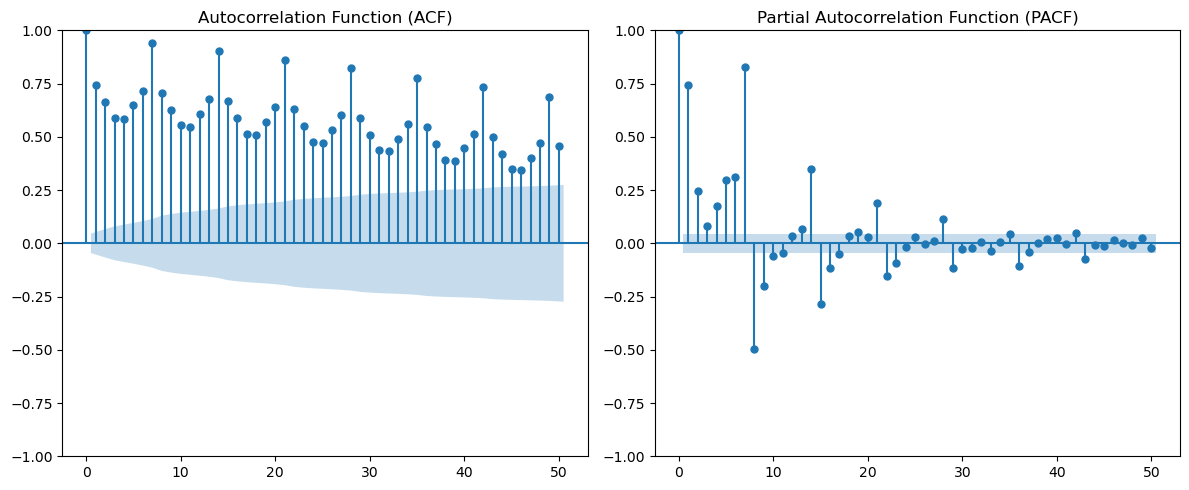

ADF Statistic: -2.8762
p-value: 0.0482

‚úÖ Data is already stationary.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.57366D+00    |proj g|=  1.27263D-01


/var/folders/bf/t7zr8nds6f727x199sygjpbh0000gn/T/ipykernel_86020/3945793495.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 This problem is unconstrained.



At iterate    5    f=  6.41012D+00    |proj g|=  3.26684D-02

At iterate   10    f=  6.39883D+00    |proj g|=  1.49002D-02

At iterate   15    f=  6.26671D+00    |proj g|=  1.33964D-01

At iterate   20    f=  6.20242D+00    |proj g|=  2.62690D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     30      1     0     0   4.742D-07   6.202D+00
  F =   6.2024005178348602     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/var/folders/bf/t7zr8nds6f727x199sygjpbh0000gn/T/ipykernel_86020/3945793495.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/bf/t7zr8nds6f727x199sygjpbh0000gn/T/ipykernel_86020/3945793495.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



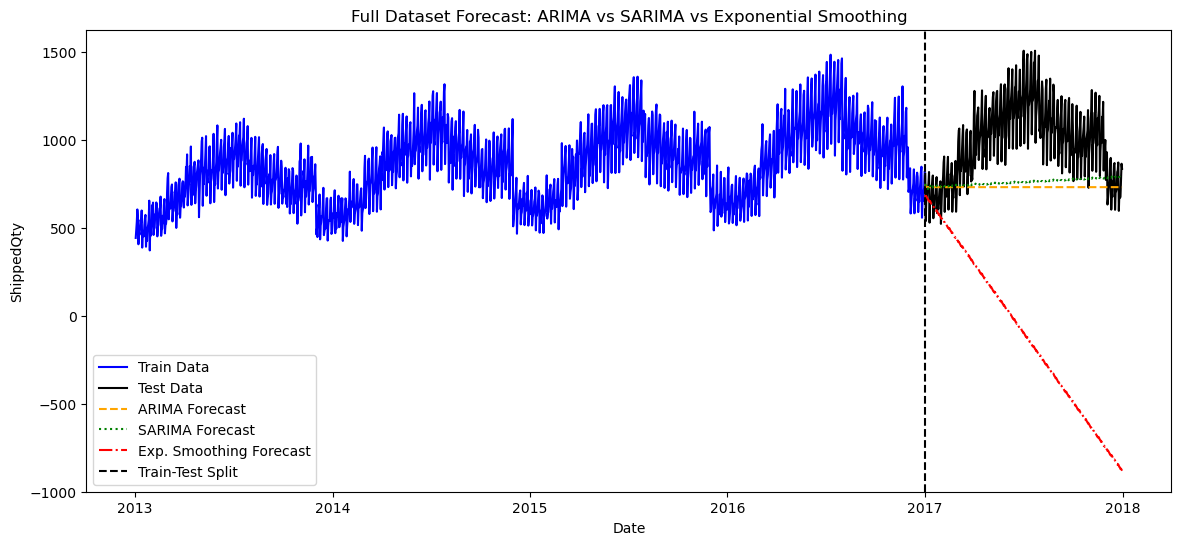

In [72]:
# Import necessary libraries
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: ACF & PACF Plots (Identifies p and q for ARIMA)
def plot_acf_pacf(data, column):
    clean_data = data[column].dropna()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plot_acf(clean_data, lags=50, alpha=0.05, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")
    plot_pacf(clean_data, lags=50, method="ywm", alpha=0.05, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")
    plt.tight_layout()
    plt.show()

plot_acf_pacf(d_df, "ShippedQty")

# Step 2: Check Data Stationarity (ADF Test)
def check_stationarity(data, column):
    adf_test = adfuller(data[column])
    print(f"ADF Statistic: {adf_test[0]:.4f}")
    print(f"p-value: {adf_test[1]:.4f}")
    return adf_test[1]

# Step 3: Apply Differencing if Needed
def apply_differencing(data, column):
    p_value = check_stationarity(data, column)
    if p_value >= 0.05:
        print("\n‚ùå Data is non-stationary. Applying first-order differencing...")
        data["ShippedQty_Diff"] = data[column].diff().dropna()
        new_p_value = check_stationarity(data.dropna(), "ShippedQty_Diff")
        if new_p_value < 0.05:
            print("‚úÖ Data is now stationary after differencing.")
    else:
        print("\n‚úÖ Data is already stationary.")

apply_differencing(train_stat, "ShippedQty")

# Step 4: Fit ARIMA Model
def fit_arima(train_data, test_data):
    arima_model = ARIMA(train_data["ShippedQty"], order=(1,1,1)).fit()
    test_data["ARIMA_Forecast"] = arima_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    return test_data, arima_model

test_stat, arima_fit = fit_arima(train_stat, test_stat)

# Step 5: Fit SARIMA Model
def fit_sarima(train_data, test_data):
    sarima_model = SARIMAX(train_data["ShippedQty"], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
    test_data["SARIMA_Forecast"] = sarima_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    return test_data, sarima_model

test_stat, sarima_fit = fit_sarima(train_stat, test_stat)

# Step 6: Fit Exponential Smoothing Model
def fit_exponential_smoothing(train_data, test_data):
    hw_model = ExponentialSmoothing(train_data["ShippedQty"], trend="add", seasonal="add", seasonal_periods=12).fit()
    test_data["ExpSmooth_Forecast"] = hw_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    return test_data, hw_model

test_stat, hw_fit = fit_exponential_smoothing(train_stat, test_stat)


# Step 8: Visualize Model Performance Over Entire Dataset
def plot_full_forecast(train_data, test_data):
    plt.figure(figsize=(14, 6))
    plt.plot(train_data["Date"], train_data["ShippedQty"], label="Train Data", color="blue")
    plt.plot(test_data["Date"], test_data["ShippedQty"], label="Test Data", color="black")
    plt.plot(test_data["Date"], test_data["ARIMA_Forecast"], label="ARIMA Forecast", linestyle="dashed", color="orange")
    plt.plot(test_data["Date"], test_data["SARIMA_Forecast"], label="SARIMA Forecast", linestyle="dotted", color="green")
    plt.plot(test_data["Date"], test_data["ExpSmooth_Forecast"], label="Exp. Smoothing Forecast", linestyle="dashdot", color="red")
    plt.axvline(x=test_data["Date"].iloc[0], color="black", linestyle="--", label="Train-Test Split")
    plt.legend()
    plt.title("Full Dataset Forecast: ARIMA vs SARIMA vs Exponential Smoothing")
    plt.xlabel("Date")
    plt.ylabel("ShippedQty")
    plt.show()

plot_full_forecast(train_stat, test_stat)

### Stat model evaluation

In [73]:
# Step 7: Overfitting Detection for Statistical Models
def check_stat_model_overfitting(y_train, y_test, y_train_pred, y_test_pred, model_name):
    return {
        "Model": model_name,
        "Train MAE": mean_absolute_error(y_train, y_train_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Train R¬≤": r2_score(y_train, y_train_pred),
        "Test R¬≤": r2_score(y_test, y_test_pred)
    }

# Get train predictions
y_train_arima_pred = arima_fit.predict(start=0, end=len(train_stat) - 1)
y_train_sarima_pred = sarima_fit.predict(start=0, end=len(train_stat) - 1)
y_train_exp_pred = hw_fit.predict(start=0, end=len(train_stat) - 1)

# Get test predictions
y_test_arima_pred = test_stat["ARIMA_Forecast"]
y_test_sarima_pred = test_stat["SARIMA_Forecast"]
y_test_exp_pred = test_stat["ExpSmooth_Forecast"]

# Store results in a list
stat_model_overfitting_results = [
    check_stat_model_overfitting(train_stat["ShippedQty"], test_stat["ShippedQty"], y_train_arima_pred, y_test_arima_pred, "ARIMA"),
    check_stat_model_overfitting(train_stat["ShippedQty"], test_stat["ShippedQty"], y_train_sarima_pred, y_test_sarima_pred, "SARIMA"),
    check_stat_model_overfitting(train_stat["ShippedQty"], test_stat["ShippedQty"], y_train_exp_pred, y_test_exp_pred, "Exponential Smoothing")
]

# Convert to DataFrame
df_stat_overfitting_results = pd.DataFrame(stat_model_overfitting_results)

# Save results as CSV for download
# df_stat_overfitting_results.to_csv("stat_overfitting_results.csv", index=False)

# Print results
print(df_stat_overfitting_results)

                   Model   Train MAE     Test MAE  Train RMSE    Test RMSE  \
0                  ARIMA   95.410212   281.062483  124.172833   339.239414   
1                 SARIMA   96.683181   258.074185  126.277070   315.407680   
2  Exponential Smoothing  101.679876  1091.290275  125.998178  1217.684609   

   Train R¬≤    Test R¬≤  
0  0.643138  -1.416455  
1  0.630941  -1.088866  
2  0.632570 -30.134054  


## Machine Learning Models for Time-Series Forecasting
### Define Features & Target

In [54]:
d_df_ml.columns

Index(['Date', 'ShippedQty', 'MinMaxScaled', 'StandardScaled', 'RobustScaled',
       'DayOfWeek', 'Month', 'Lag_1', 'Lag_7', 'Lag_14', 'Lag_30', 'Rolling_7',
       'Rolling_7_Std', 'DayOfWeek_Sin', 'DayOfWeek_Cos', 'Month_Sin',
       'Month_Cos', 'Lag_1_to_Lag_7_Ratio', 'Lag_7_to_Lag_14_Ratio'],
      dtype='object')

In [55]:
# Define Features (X) and Target (y)
features = ["Lag_1", "Lag_7", "Lag_14", "Lag_30", "Rolling_7", "Rolling_7_Std",
            "DayOfWeek_Sin", "DayOfWeek_Cos", "Month_Sin", "Month_Cos", "Lag_1_to_Lag_7_Ratio", "Lag_7_to_Lag_14_Ratio"]

X_train, X_test = d_df_ml.iloc[:train_size][features], d_df_ml.iloc[train_size:][features]
y_train, y_test = d_df_ml.iloc[:train_size]["ShippedQty"], d_df_ml.iloc[train_size:]["ShippedQty"]

In [56]:
d_df_ml

Date  ShippedQty  MinMaxScaled  StandardScaled  RobustScaled  \
0    2013-01-31       514.0      0.125922       -1.686135     -1.121140   
1    2013-02-01       627.0      0.225427       -1.165961     -0.763262   
2    2013-02-02       604.0      0.205173       -1.271837     -0.836105   
3    2013-02-03       643.0      0.239516       -1.092308     -0.712589   
4    2013-02-04       459.0      0.077490       -1.939317     -1.295329   
...         ...         ...           ...             ...           ...   
1791 2017-12-27       670.0      0.263291       -0.968019     -0.627078   
1792 2017-12-28       675.0      0.267694       -0.945002     -0.611243   
1793 2017-12-29       778.0      0.358393       -0.470862     -0.285036   
1794 2017-12-30       864.0      0.434122       -0.074977     -0.012668   
1795 2017-12-31       836.0      0.409466       -0.203870     -0.101346   

      DayOfWeek  Month  Lag_1  Lag_7  Lag_14  Lag_30   Rolling_7  \
0             3      1  455.0  497.0   451.0   453.0  510.428571   
1             4      2  514.0  516.0   516.0   442.0  526.285714   
2             5      2  627.0  544.0   552.0   487.0  534.857143   
3             6      2  604.0  654.0   573.0   533.0  533.285714   
4             0      2  643.0  371.0   392.0   604.0  545.857143   
...         ...    ...    ...    ...     ...     ...         ...   
1791          2     12  700.0  708.0   675.0   825.0  743.571429   
1792          3     12  670.0  724.0   766.0   985.0  736.571429   
1793          4     12  675.0  817.0   773.0   947.0  731.000000   
1794          5     12  778.0  827.0   859.0   999.0  736.285714   
1795          6     12  864.0  871.0   868.0   772.0  731.285714   

      Rolling_7_Std  DayOfWeek_Sin  DayOfWeek_Cos     Month_Sin  Month_Cos  \
0         85.993909       0.433884      -0.900969  5.000000e-01   0.866025   
1         96.753491      -0.433884      -0.900969  8.660254e-01   0.500000   
2        101.142521      -0.974928      -0.222521  8.660254e-01   0.500000   
3         99.046646      -0.781831       0.623490  8.660254e-01   0.500000   
4         78.461091       0.000000       1.000000  8.660254e-01   0.500000   
...             ...            ...            ...           ...        ...   
1791      98.371502       0.974928      -0.222521 -2.449294e-16   1.000000   
1792     101.683917       0.433884      -0.900969 -2.449294e-16   1.000000   
1793      97.526065      -0.433884      -0.900969 -2.449294e-16   1.000000   
1794     104.359498      -0.974928      -0.222521 -2.449294e-16   1.000000   
1795      97.438381      -0.781831       0.623490 -2.449294e-16   1.000000   

      Lag_1_to_Lag_7_Ratio  Lag_7_to_Lag_14_Ratio  
0                 0.915493               1.101996  
1                 0.996124               1.000000  
2                 1.152574               0.985507  
3                 0.923547               1.141361  
4                 1.733154               0.946429  
...                    ...                    ...  
1791              0.988701               1.048889  
1792              0.925414               0.945170  
1793              0.826193               1.056921  
1794              0.940750               0.962747  
1795              0.991963               1.003456  

[1796 rows x 19 columns]

### Train & Evaluate Baseline ML Models

In [76]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net": ElasticNet()
}

# Initialize results lists
results = []
overfitting_results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test set

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R¬≤": r2})

    # Overfitting check
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    overfitting_results.append({
        "Model": name,
        "Train MAE": train_mae, "Test MAE": mae,
        "Train RMSE": train_rmse, "Test RMSE": rmse,
        "Train R¬≤": train_r2, "Test R¬≤": r2
    })

# Convert results into DataFrame
df_results = pd.DataFrame(results)
df_overfitting_results = pd.DataFrame(overfitting_results)


# Print results
print("üìä Linear Model Performance:")
print(df_results)
print("\nüîç Overfitting Check for Linear Models:")
print(df_overfitting_results)

üìä Linear Model Performance:
               Model        MAE       RMSE        R¬≤
0  Linear Regression  48.606988  64.454387  0.902094
1   Ridge Regression  48.368693  64.530961  0.901861
2   Lasso Regression  48.208805  65.443043  0.899067
3        Elastic Net  49.444268  68.185875  0.890430

üîç Overfitting Check for Linear Models:
               Model  Train MAE   Test MAE  Train RMSE  Test RMSE  Train R¬≤  \
0  Linear Regression  41.418603  48.606988   55.229364  64.454387  0.926109   
1   Ridge Regression  41.564155  48.368693   55.351191  64.530961  0.925782   
2   Lasso Regression  41.759901  48.208805   56.052087  65.443043  0.923891   
3        Elastic Net  42.907555  49.444268   58.440091  68.185875  0.917268   

    Test R¬≤  
0  0.902094  
1  0.901861  
2  0.899067  
3  0.890430  


### Train Advanced Tree-Based Models

In [77]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define models
tree_models = {
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "XGBoost": XGBRegressor(n_estimators=100),
    "LightGBM": LGBMRegressor(n_estimators=100),
    "CatBoost": CatBoostRegressor(n_estimators=100, verbose=0)
}

# Initialize results lists
tree_results = []
overfitting_results = []

# Train and evaluate tree-based models
for name, model in tree_models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test set

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    tree_results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R¬≤": r2})

    # Overfitting check
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    overfitting_results.append({
        "Model": name,
        "Train MAE": train_mae, "Test MAE": mae,
        "Train RMSE": train_rmse, "Test RMSE": rmse,
        "Train R¬≤": train_r2, "Test R¬≤": r2
    })

# Convert results into DataFrames
df_tree_results = pd.DataFrame(tree_results)
df_overfitting_results = pd.DataFrame(overfitting_results)

# Print results
print("üìä Tree-Based Model Performance:")
print(df_tree_results)
print("\nüîç Overfitting Check for Tree-Based Models:")
print(df_overfitting_results)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 12
[LightGBM] [Info] Start training from score 856.736301
üìä Tree-Based Model Performance:
           Model        MAE       RMSE        R¬≤
0  Random Forest  38.576905  52.329143  0.935466
1        XGBoost  38.244151  50.156380  0.940713
2       LightGBM  34.997211  46.290865  0.949500
3       CatBoost  35.180743  44.374880  0.953594

üîç Overfitting Check for Tree-Based Models:
           Model  Train MAE   Test MAE  Train RMSE  Test RMSE  Train R¬≤  \
0  Random Forest  12.919110  38.576905   17.296504  52.329143  0.992753   
1        XGBoost   2.287172  38.244151    3.152652  50.156380  0.999759   
2       LightGBM  13.743284  34.997211   17.746157  46.290865  0.992371   
3       CatBoost  16.774640 

### Support Vector Regression 

In [78]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Define and train the SVR model
svr_model = SVR(kernel="rbf", C=1.0, epsilon=0.1)  # C controls regularization, epsilon defines margin of tolerance
svr_model.fit(X_train, y_train)

# Predict on test data
y_pred_svr = svr_model.predict(X_test)

# Evaluate SVR model
svr_results = {
    "Model": "Support Vector Regression (SVR)",
    "MAE": mean_absolute_error(y_test, y_pred_svr),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_svr)),
    "R¬≤": r2_score(y_test, y_pred_svr)
}

# Overfitting check
y_train_pred_svr = svr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred_svr)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_svr))
train_r2 = r2_score(y_train, y_train_pred_svr)

svr_overfitting_results = {
    "Model": "Support Vector Regression (SVR)",
    "Train MAE": train_mae, "Test MAE": svr_results["MAE"],
    "Train RMSE": train_rmse, "Test RMSE": svr_results["RMSE"],
    "Train R¬≤": train_r2, "Test R¬≤": svr_results["R¬≤"]
}

# Convert to DataFrames
df_svr_results = pd.DataFrame([svr_results])
df_svr_overfitting_results = pd.DataFrame([svr_overfitting_results])

# Print results
print("üìä SVR Model Performance:")
print(df_svr_results)
print("\nüîç Overfitting Check for SVR:")
print(df_svr_overfitting_results)

üìä SVR Model Performance:
                             Model         MAE        RMSE        R¬≤
0  Support Vector Regression (SVR)  132.370526  166.439905  0.347141

üîç Overfitting Check for SVR:
                             Model   Train MAE    Test MAE  Train RMSE  \
0  Support Vector Regression (SVR)  100.710017  132.370526  125.133372   

    Test RMSE  Train R¬≤   Test R¬≤  
0  166.439905  0.620686  0.347141  


### Ensemble Models (Stacking, Blending)
#### Stacking Regressor (Combining Multiple Models)

In [79]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Define base models for stacking using the recommended combination
base_models = [
    ("catboost", CatBoostRegressor(n_estimators=100, verbose=0)),  # Handles categorical features well
    ("lightgbm", LGBMRegressor(n_estimators=100)),  # Efficient boosting for large datasets
    ("xgboost", XGBRegressor(n_estimators=100)),  # Strong performance for structured data
    ("ridge", Ridge()),  # Adds linear generalization component
    ("svr", SVR(kernel="rbf"))  # Captures non-linearity
]

# Define meta-model (final estimator trained on base model predictions)
meta_model = Ridge()

# Create stacking regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, passthrough=True)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict on train and test data
y_train_pred_stacking = stacking_model.predict(X_train)
y_test_pred_stacking = stacking_model.predict(X_test)

# Evaluate stacking model performance
stacking_results = {
    "Model": "Stacking (CatBoost + LightGBM + XGBoost + Ridge + SVR)",
    "Test MAE": mean_absolute_error(y_test, y_test_pred_stacking),
    "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred_stacking)),
    "Test R¬≤": r2_score(y_test, y_test_pred_stacking)
}

# Overfitting check (Train vs. Test Scores)
train_mae = mean_absolute_error(y_train, y_train_pred_stacking)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_stacking))
train_r2 = r2_score(y_train, y_train_pred_stacking)

stacking_overfitting_results = {
    "Model": "Stacking (CatBoost + LightGBM + XGBoost + Ridge + SVR)",
    "Train MAE": train_mae, "Test MAE": stacking_results["Test MAE"],
    "Train RMSE": train_rmse, "Test RMSE": stacking_results["Test RMSE"],
    "Train R¬≤": train_r2, "Test R¬≤": stacking_results["Test R¬≤"]
}

# Convert to DataFrames
df_stacking_results = pd.DataFrame([stacking_results])
df_stacking_overfitting_results = pd.DataFrame([stacking_overfitting_results])

# Print results
print("üìä Stacking Model Performance:")
print(df_stacking_results)
print("\nüîç Overfitting Check for Stacking Model:")
print(df_stacking_overfitting_results)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 12
[LightGBM] [Info] Start training from score 856.736301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 12
[LightGBM] [Info] Start training from score 877.362158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2076
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 12
[LightGBM] [Info] Start tr